In [23]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior
import gc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

### Try to test how kappa transforms into beta

In [2]:
from popsed.nde import _inv_beta_cdf, _beta_cdf
def gen_truth(N_samples=5000):
    ncomp = 4
    priors = prior.load_priors([
            # flat dirichilet priors for SFH
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.3),
            prior.UniformPrior(0., 1.,),
            prior.UniformPrior(0., 1.,),
            # uniform priors on the mass fraction of burst
            prior.TruncatedNormalPrior(0, 1, 0.1, 0.2, label='fburst'),
            # uniform priors on star-burst lookback time
            prior.TruncatedNormalPrior(1e-2, 13.27, 12, 7, label='tburst'),
            # uniform priors on log-metallicity, absolute Z
#             prior.UniformPrior(-2.6, 0.3, label='logzsol'),
            prior.TruncatedNormalPrior(-2.6, 0.3, -1.2, 0.9, label='logzsol'),
            # uniform priors on dust1
#             prior.UniformPrior(0., 3., label='dust1'),
            prior.TruncatedNormalPrior(0., 3., 1, 0.8, label='dust1'),
            # uniform priors on dust2
#             prior.BiGaussianPrior([0.3, 1.0], [[0.02, 0], [0, 0.05]], p1=0.3, label='dust2'),
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.5, label='dust2'),
            # uniform priors on dust_index
            prior.TruncatedNormalPrior(-3., 1., 3, 1, label='dust_index'),
            # uniformly sample redshift
#             prior.TruncatedNormalPrior(0, 0.78, 0.18, 0.1, label='redshift')
#             prior.TruncatedNormalPrior(7.5, 13, 11.0, 0.7, label='logmstar')
#             prior.TruncatedNormalPrior(0., 1.5, 0.08, 0.05, label='redshift')
        ])
    
    _thetas_unt = np.array([priors.sample() for i in range(N_samples)])
#     _thetas_unt[:, 1] = _beta_cdf(np.random.uniform(0, 1, N_samples), 2, 1)
    for i in range(3):
        _thetas_unt[:, i:i + 1] = _inv_beta_cdf(_thetas_unt[:, i:i + 1], 3 - i, 1)
    _thetas = np.hstack([
#                _thetas_unt[:, 0:1], 
               prior.FlatDirichletPrior(4).transform(_thetas_unt[:, 0:3]), 
               _thetas_unt[:, 3:]])
    
    return _thetas, _thetas_unt

In [3]:
# z_mass_mock = np.load('./NDE/GAMA/NMF/z_mass_mock.npy')
# z_mass_mock = np.load('./reference_catalog/GAMA/gama_clean_z_mass_lambdar.npy')[:, :2]
z_mass_mock = np.load('./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch.npy')[:, :2] # _snr1
z_mass_mock = z_mass_mock[(z_mass_mock[:, 1] > 7.5) & (z_mass_mock[:, 1] < 13) & (z_mass_mock[:, 0] < 0.65)]
z_mass_mock = z_mass_mock[np.random.randint(0, len(z_mass_mock), 120000)]

In [4]:
_thetas, _thetas_unt = gen_truth(N_samples=len(z_mass_mock)) # slow

In [5]:
params = np.hstack([_thetas, z_mass_mock])
params_unt = np.hstack([_thetas_unt, z_mass_mock])

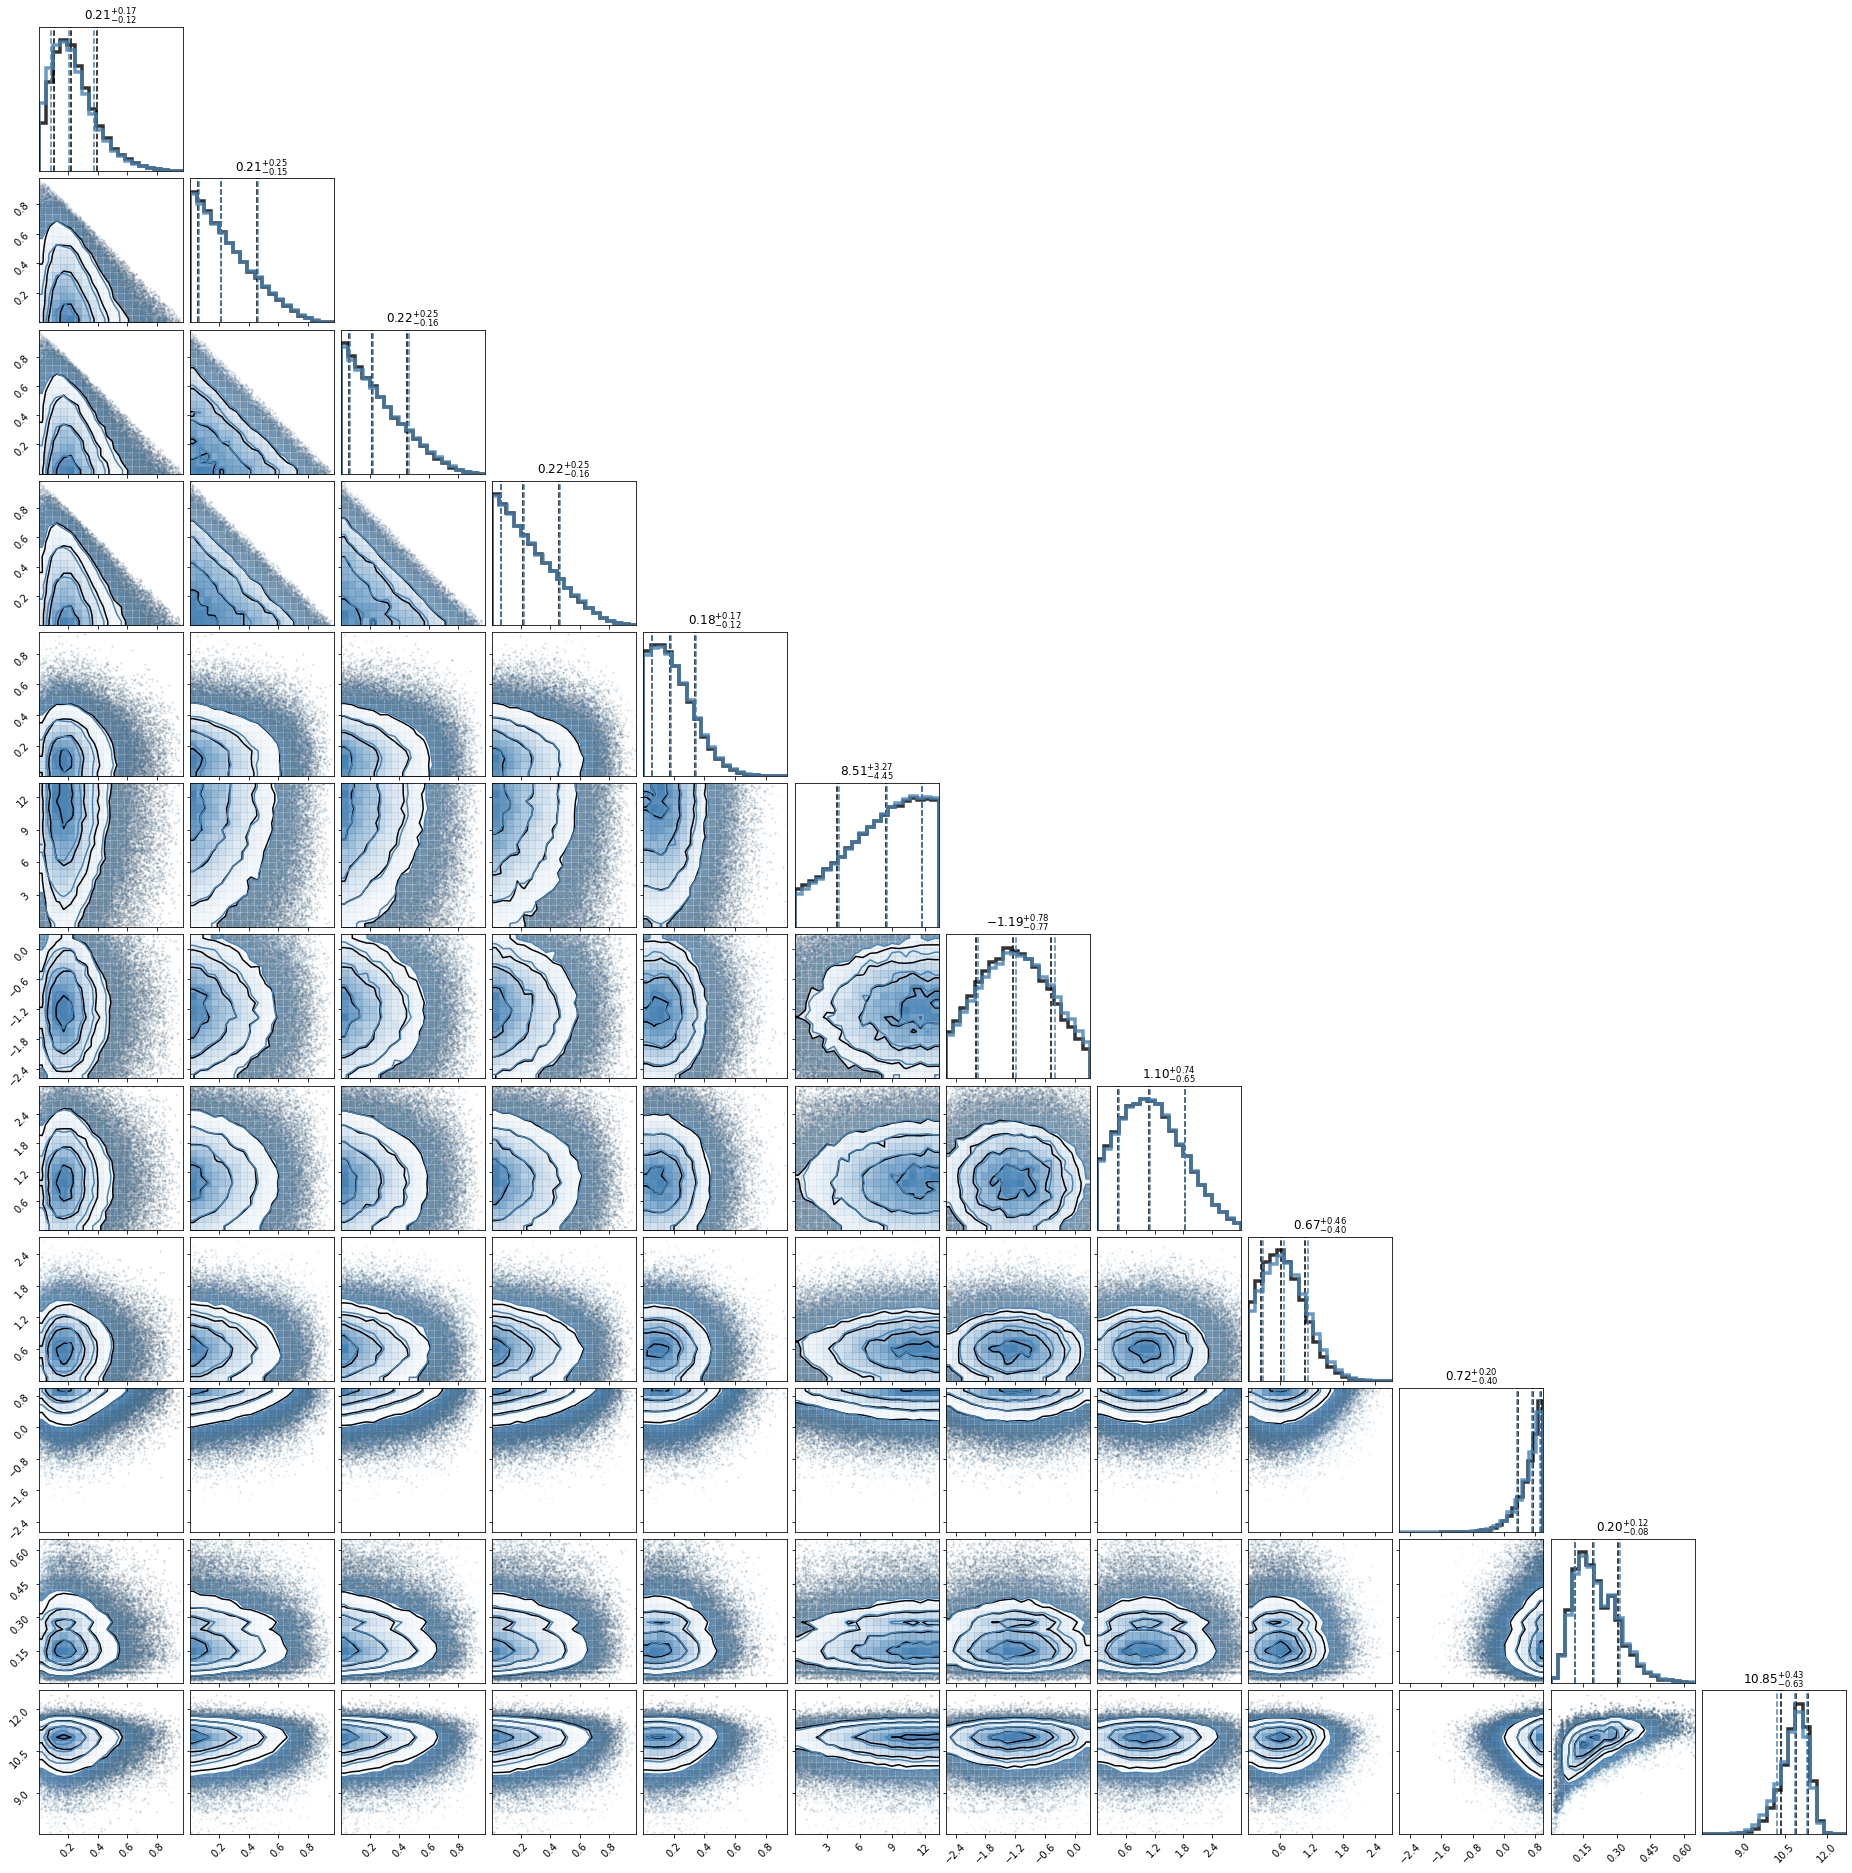

In [12]:
figure = corner.corner(params[flag], #params, 
                       quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

figure = corner.corner(params, 
                       fig=figure, color='steelblue',
                       quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [6]:
name = 'NMF'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

PHOT = 'AUTO'
noise = 'gama_snr'
noise_model_dir = f'./noise_model/gama_snr_model_mag_dr3_apmatch_{PHOT}.npy'

# noise = 'gama'
# noise_model_dir = f'./noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [7]:
test_par = torch.Tensor(params_unt).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(test_par, noise=noise, SNR=1,
                                                  noise_model_dir=noise_model_dir).detach().cpu().numpy()
flag = (speculator._snrs[:, 0].detach().cpu().numpy() > 1)

params_unt = params_unt[flag]
mags = mags[flag]

In [8]:
len(mags)

100863

In [10]:
np.save('./NDE/GAMA/NMF/mock_mags_dr3apmatch_noise_2.npy', mags)
np.save('./NDE/GAMA/NMF/mock_params_dr3apmatch_2.npy', params_unt)

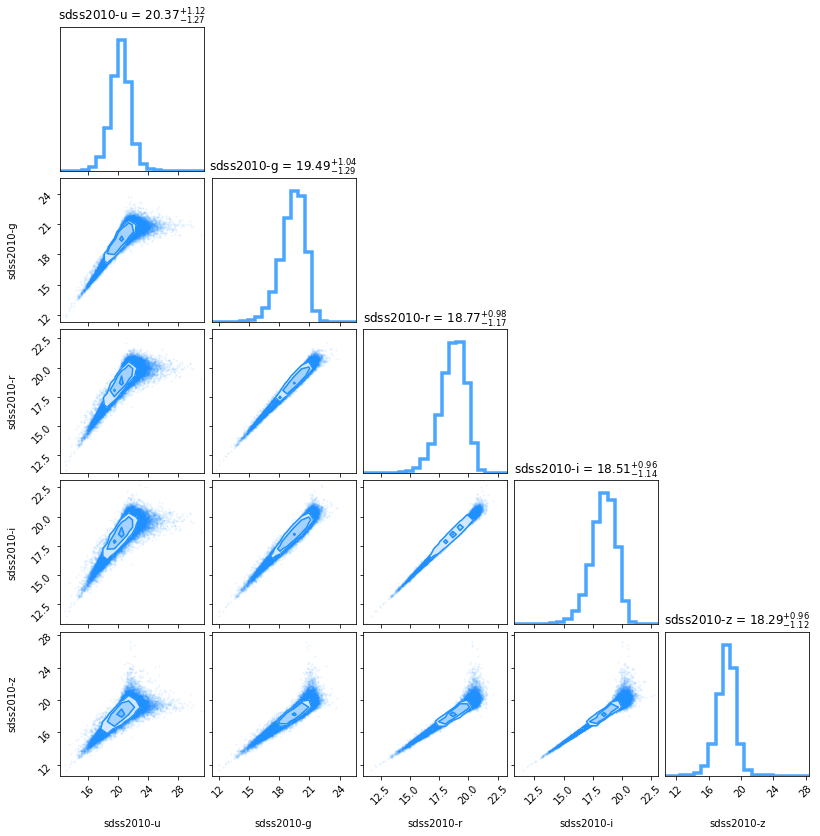

In [11]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = gama_filters

figure = corner.corner(mags,
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

In [15]:
# params_unt = np.load('./NDE/GAMA/NMF/mock_params_dr3apmatch.npy')

In [16]:
# test_par = torch.Tensor(params_unt).to('cuda')
# mags = speculator._predict_mag_with_mass_redshift(test_par, noise=None,
#                                            noise_model_dir=noise_model_dir).detach().cpu().numpy()
# np.save('./NDE/GAMA/NMF/mock_mags_dr3apmatch_no_noise.npy', mags)
# del mags
# torch.cuda.empty_cache()
# gc.collect()

# mags = speculator._predict_mag_with_mass_redshift(test_par, noise=noise, SNR=1,
#                                            noise_model_dir=noise_model_dir).detach().cpu().numpy()
# np.save('./NDE/GAMA/NMF/mock_mags_dr3apmatch_noise.npy', mags)
# del mags
# torch.cuda.empty_cache()
# gc.collect()

# mags = speculator._predict_mag_with_mass_redshift(test_par, noise=None, SNR=3,
#                                            noise_model_dir=noise_model_dir).detach().cpu().numpy()
# np.save('./NDE/GAMA/NMF/mock_mags_dr3apmatch_snr3.npy', mags)
# del mags
# torch.cuda.empty_cache()
# gc.collect()

8

#### Load GAMA photometry catalog

In [13]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [14]:
name = 'NMF'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

PHOT = 'AUTO'
noise = 'gama_snr'
noise_model_dir = f'./noise_model/gama_snr_model_mag_dr3_apmatch_{PHOT}.npy'

In [15]:
X_data = np.load('./NDE/GAMA/NMF/mock_mags_dr3apmatch_noise_2.npy')[:, :]
print('Total number of samples:', len(X_data))

Total number of samples: 100863


In [16]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [41]:
# Determine the intrinsic sampling loss
X_datas = []
for i in range(5):
    ind = np.random.randint(0, len(X_data), 10000)
    X_datas.append(torch.Tensor(X_data[ind]).to('cuda'))
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.002, 'scaling': 0.9})
intr_loss = []
for i in range(5):
    dataloader = DataLoader(X_data, batch_size=10000, shuffle=True)
    data_loss = 0.
    for x in dataloader:
        data_loss += L(X_datas[i], x.to('cuda'))
    loss = data_loss / len(dataloader)
    intr_loss.append(loss.item())

print("Intrinsic sampling loss:", np.mean(intr_loss), '+-', np.std(intr_loss))
del X_datas
gc.collect()
torch.cuda.empty_cache()

Intrinsic sampling loss: 0.2616092264652252 +- 0.0012230035317344198


In [17]:
scaler = StandardScaler(device='cpu')
scaler.fit(X_data)
_X_data = scaler.transform(X_data)
# Determine the intrinsic sampling loss
X_datas = []
for i in range(5):
    ind = np.random.randint(0, len(_X_data), 10000)
    X_datas.append(torch.Tensor(_X_data[ind]).to('cuda'))
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.002, 'scaling': 0.9})
intr_loss = []
for i in range(5):
    dataloader = DataLoader(_X_data, batch_size=10000, shuffle=True)
    data_loss = 0.
    for x in dataloader:
        data_loss += L(X_datas[i], x.to('cuda'))
    loss = data_loss / len(dataloader)
    intr_loss.append(loss.item())

print("Intrinsic sampling loss:", np.mean(intr_loss), '+-', np.std(intr_loss))
del X_datas
gc.collect()
torch.cuda.empty_cache()

Intrinsic sampling loss: 0.13022386133670807 +- 0.0007418624668000002


In [25]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [26]:
_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0., 0.8])
_prior_NDE[-1] = np.array([7.5, 13.])

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

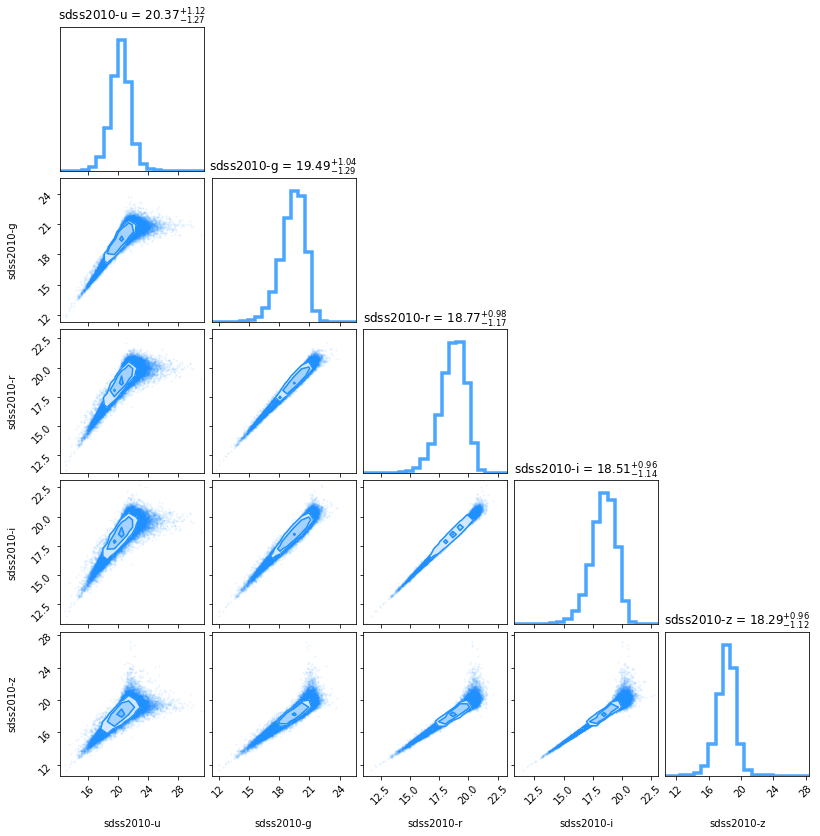

In [19]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = gama_filters

figure = corner.corner(X_data,
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

p = 1
blur = 0.1, loss=0.07
blur = 0.01, loss=0.196
blur = 0.002, loss=0.204

p = 2
blur = 0.1, loss=0.012
blur = 0.01, loss=0.02
blur = 0.002, loss=0.0184

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

### now we provide the redshift distribution to it

In [20]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [21]:
seed = 39
np.random.seed(seed)

_bounds = np.zeros_like(speculator.bounds)
_bounds = np.zeros_like(_bounds)
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 10),
                    np.abs(np.random.normal(size=len(_bounds)) / 10)]).T
_stds = np.ones(len(_bounds))

X_train, X_vali = train_test_split(X_data, test_size=0.15)
if name == 'NMF_ZH':
    Y_train = torch.ones(len(X_train), 12)
else:
    Y_train = torch.ones(len(X_train), 11)

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name=name,
                                              num_transforms=20,
                                              num_bins=60,
                                              hidden_features=100,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True,
                                              NDE_prior=_prior_NDE)
NDE_theta.build(
    Y_train,
    X_train,
    z_score=True,
    filterset=gama_filters,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name
NDE_theta.external_redshift_data = None  # z_nsa

NDE_theta.output_dir = './NDE/GAMA/anneal/mock/test_dr3/'

print('Total number of params in the model:',
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

[-0.02143246  0.10385468  0.05495897  0.00203954 -0.0078713  -0.0639371
 -0.05413566 -0.07056593 -0.0204677   0.10109083  0.02412641]
Total number of params in the model: 2812330


In [22]:
max_epochs = 40
anneal_coeff = 20
anneal_tau = 12
max_lr = 3e-4
add_penalty = False
n_samples = 10000

blurs = [0.3, 0.3, 0.2, 0.2, 0.1, 0.1,
         0.1, 0.05, 0.05, 0.05] + [0.002] * max_epochs
snrs = [1 + anneal_coeff * np.exp(- anneal_tau / max_epochs * i)
        for i in range(max_epochs)]  # larger anneal_coeff, after annealing
steps = 30

try:
    print('### Training NDE for seed {0}'.format(seed))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                    max_lr=max_lr,
                                                    steps_per_epoch=steps,
                                                    epochs=max_epochs,
                                                    div_factor=10, final_div_factor=100)
    for i, epoch in enumerate(range(max_epochs)):
        np.save(os.path.join(NDE_theta.output_dir, f'{NDE_theta.method}_{NDE_theta.seed}_sample_{i+1}.npy'),
                NDE_theta.sample(5000).detach().cpu().numpy())

        print('    Epoch {0}'.format(epoch))
        print('\n\n')
        print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
        NDE_theta.train(n_epochs=steps,
                        speculator=speculator,
                        add_penalty=add_penalty,
                        n_samples=n_samples,
                        noise=noise,
                        noise_model_dir=noise_model_dir,
                        SNR=snrs[i],
                        sinkhorn_kwargs={
                            'p': 1, 'blur': blurs[i], 'scaling': 0.9},
                        scheduler=scheduler
                        )

    print(f'    Succeeded in training for {max_epochs} epochs!')
    print('    Saving NDE model for seed {0}'.format(seed))
    print('\n\n')
    np.save(os.path.join(NDE_theta.output_dir, f'{NDE_theta.method}_{NDE_theta.seed}_sample_{i+1}.npy'),
            NDE_theta.sample(5000).detach().cpu().numpy())
    NDE_theta.save_model(
        os.path.join(NDE_theta.output_dir,
                     f'nde_theta_last_model_{NDE_theta.method}_{NDE_theta.seed}.pkl'))
    
except Exception as e:
    print(e)

### Training NDE for seed 39
    Epoch 0



    lr: 3.0000000000000024e-05


Loss = 5.854 (train), 5.801 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [01:32<00:00,  3.08s/epochs]


    Epoch 1



    lr: 3.46255284009611e-05


Loss = 3.872 (train), 3.860 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [01:31<00:00,  3.05s/epochs]


    Epoch 2



    lr: 4.818514304105758e-05


Loss = 2.125 (train), 2.178 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [01:34<00:00,  3.16s/epochs]


    Epoch 3



    lr: 6.974965306660288e-05


Loss = 0.631 (train), 0.649 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [01:32<00:00,  3.10s/epochs]


    Epoch 4



    lr: 9.784132138758255e-05


Loss = 0.199 (train), 0.190 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [01:36<00:00,  3.22s/epochs]


    Epoch 5



    lr: 0.00013053512860178822


Loss = 0.101 (train), 0.103 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [01:42<00:00,  3.40s/epochs]


    Epoch 6



    lr: 0.0001655906875417405


Loss = 0.076 (train), 0.080 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [01:37<00:00,  3.27s/epochs]


    Epoch 7



    lr: 0.0002006057688224274


Loss = 0.130 (train), 0.135 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [01:41<00:00,  3.37s/epochs]


    Epoch 8



    lr: 0.00023318091684494847


Loss = 0.104 (train), 0.110 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [01:41<00:00,  3.40s/epochs]


    Epoch 9



    lr: 0.00026108387572273067


Loss = 0.090 (train), 0.095 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [01:41<00:00,  3.37s/epochs]


    Epoch 10



    lr: 0.00028240255762229216


Loss = 0.168 (train), 0.185 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:13<00:00,  4.43s/epochs]


    Epoch 11



    lr: 0.00029567607115700355


Loss = 0.170 (train), 0.181 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.37s/epochs]


    Epoch 12



    lr: 0.000299998951985193


Loss = 0.152 (train), 0.158 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.37s/epochs]


    Epoch 13



    lr: 0.00029899398426138854


Loss = 0.148 (train), 0.157 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.37s/epochs]


    Epoch 14



    lr: 0.0002961172170742058


Loss = 0.148 (train), 0.153 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 15



    lr: 0.0002914048274401629


Loss = 0.142 (train), 0.148 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 16



    lr: 0.00028491607639310004


Loss = 0.154 (train), 0.166 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 17



    lr: 0.00027673256374229505


Loss = 0.137 (train), 0.146 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:10<00:00,  4.36s/epochs]


    Epoch 18



    lr: 0.0002669572019075165


Loss = 0.135 (train), 0.146 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 19



    lr: 0.00025571292173563374


Loss = 0.136 (train), 0.143 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:10<00:00,  4.36s/epochs]


    Epoch 20



    lr: 0.00024314112657389153


Loss = 0.136 (train), 0.143 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 21



    lr: 0.0002293999140407742


Loss = 0.145 (train), 0.150 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:10<00:00,  4.37s/epochs]


    Epoch 22



    lr: 0.00021466208785672302


Loss = 0.136 (train), 0.142 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.37s/epochs]


    Epoch 23



    lr: 0.00019911298473708827


Loss = 0.134 (train), 0.143 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.39s/epochs]


    Epoch 24



    lr: 0.00018294814367539916


Loss = 0.134 (train), 0.139 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 25



    lr: 0.00016637084692706572


Loss = 0.133 (train), 0.142 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 26



    lr: 0.0001495895636170698


Loss = 0.141 (train), 0.144 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:10<00:00,  4.36s/epochs]


    Epoch 27



    lr: 0.000132815328119762


Loss = 0.133 (train), 0.141 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 28



    lr: 0.00011625908617915905


Loss = 0.132 (train), 0.139 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:10<00:00,  4.36s/epochs]


    Epoch 29



    lr: 0.00010012904214381942


Loss = 0.134 (train), 0.139 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:10<00:00,  4.36s/epochs]


    Epoch 30



    lr: 8.462804067635702e-05


Loss = 0.132 (train), 0.138 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:10<00:00,  4.36s/epochs]


    Epoch 31



    lr: 6.995101586411577e-05


Loss = 0.135 (train), 0.150 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.37s/epochs]


    Epoch 32



    lr: 5.628253980991776e-05


Loss = 0.131 (train), 0.138 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 33



    lr: 4.379450153077901e-05


Loss = 0.133 (train), 0.140 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.37s/epochs]


    Epoch 34



    lr: 3.264394535378832e-05


Loss = 0.132 (train), 0.140 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.39s/epochs]


    Epoch 35



    lr: 2.297109599257474e-05


Loss = 0.133 (train), 0.140 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 36



    lr: 1.4897595140173416e-05


Loss = 0.133 (train), 0.140 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 37



    lr: 8.52497175415759e-06


Loss = 0.136 (train), 0.142 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.39s/epochs]


    Epoch 38



    lr: 3.933365271088682e-06


Loss = 0.138 (train), 0.143 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.38s/epochs]


    Epoch 39



    lr: 1.1805178066034097e-06


Loss = 0.134 (train), 0.142 (vali), 0.000 (bad ratio): 100%|█████████████████| 30/30 [02:11<00:00,  4.37s/epochs]


    Succeeded in training for 40 epochs!
    Saving NDE model for seed 39





In [57]:
# del X_data
gc.collect()
torch.cuda.empty_cache()

(0.05044178528487399, 0.6)

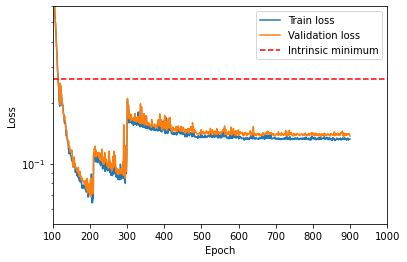

In [27]:
NDE_theta.plot_loss(0.261)
plt.yscale('log')

plt.xlim(100, 1000)
plt.ylim(0, 0.6)

In [27]:
samples = NDE_theta.sample(5000)
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                      _samples_unt[:, 3:-1], 
                      _samples_unt[:, -1:]])

0 5000
>40 0


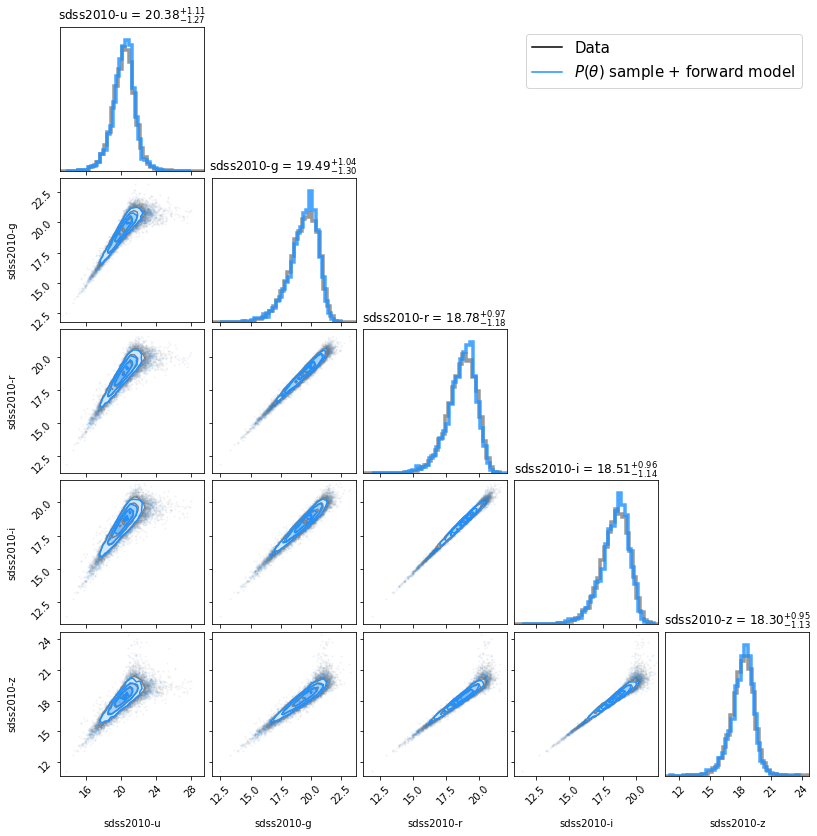

In [28]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = gama_filters

figure = corner.corner(X_vali,#.cpu().detach().numpy(), 
                       color='gray', labels=labels, bins=40,
                       smooth=0.2, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(
#     inverse_transform_nmf_params_given_z(samples, NDE_theta.NDE_prior, NDE_theta.cdf_z), 
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir, SNR=1,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=40,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [29]:
true_params_unt = np.load('./NDE/GAMA/NMF/mock_params_dr3apmatch.npy')
true_params_unt = true_params_unt[np.random.randint(0, len(true_params_unt), 5000)]
true_params = np.hstack([prior.FlatDirichletPrior(4).transform(true_params_unt[:, :3]),
                      true_params_unt[:, 3:-1], 
                      true_params_unt[:, -1:]])

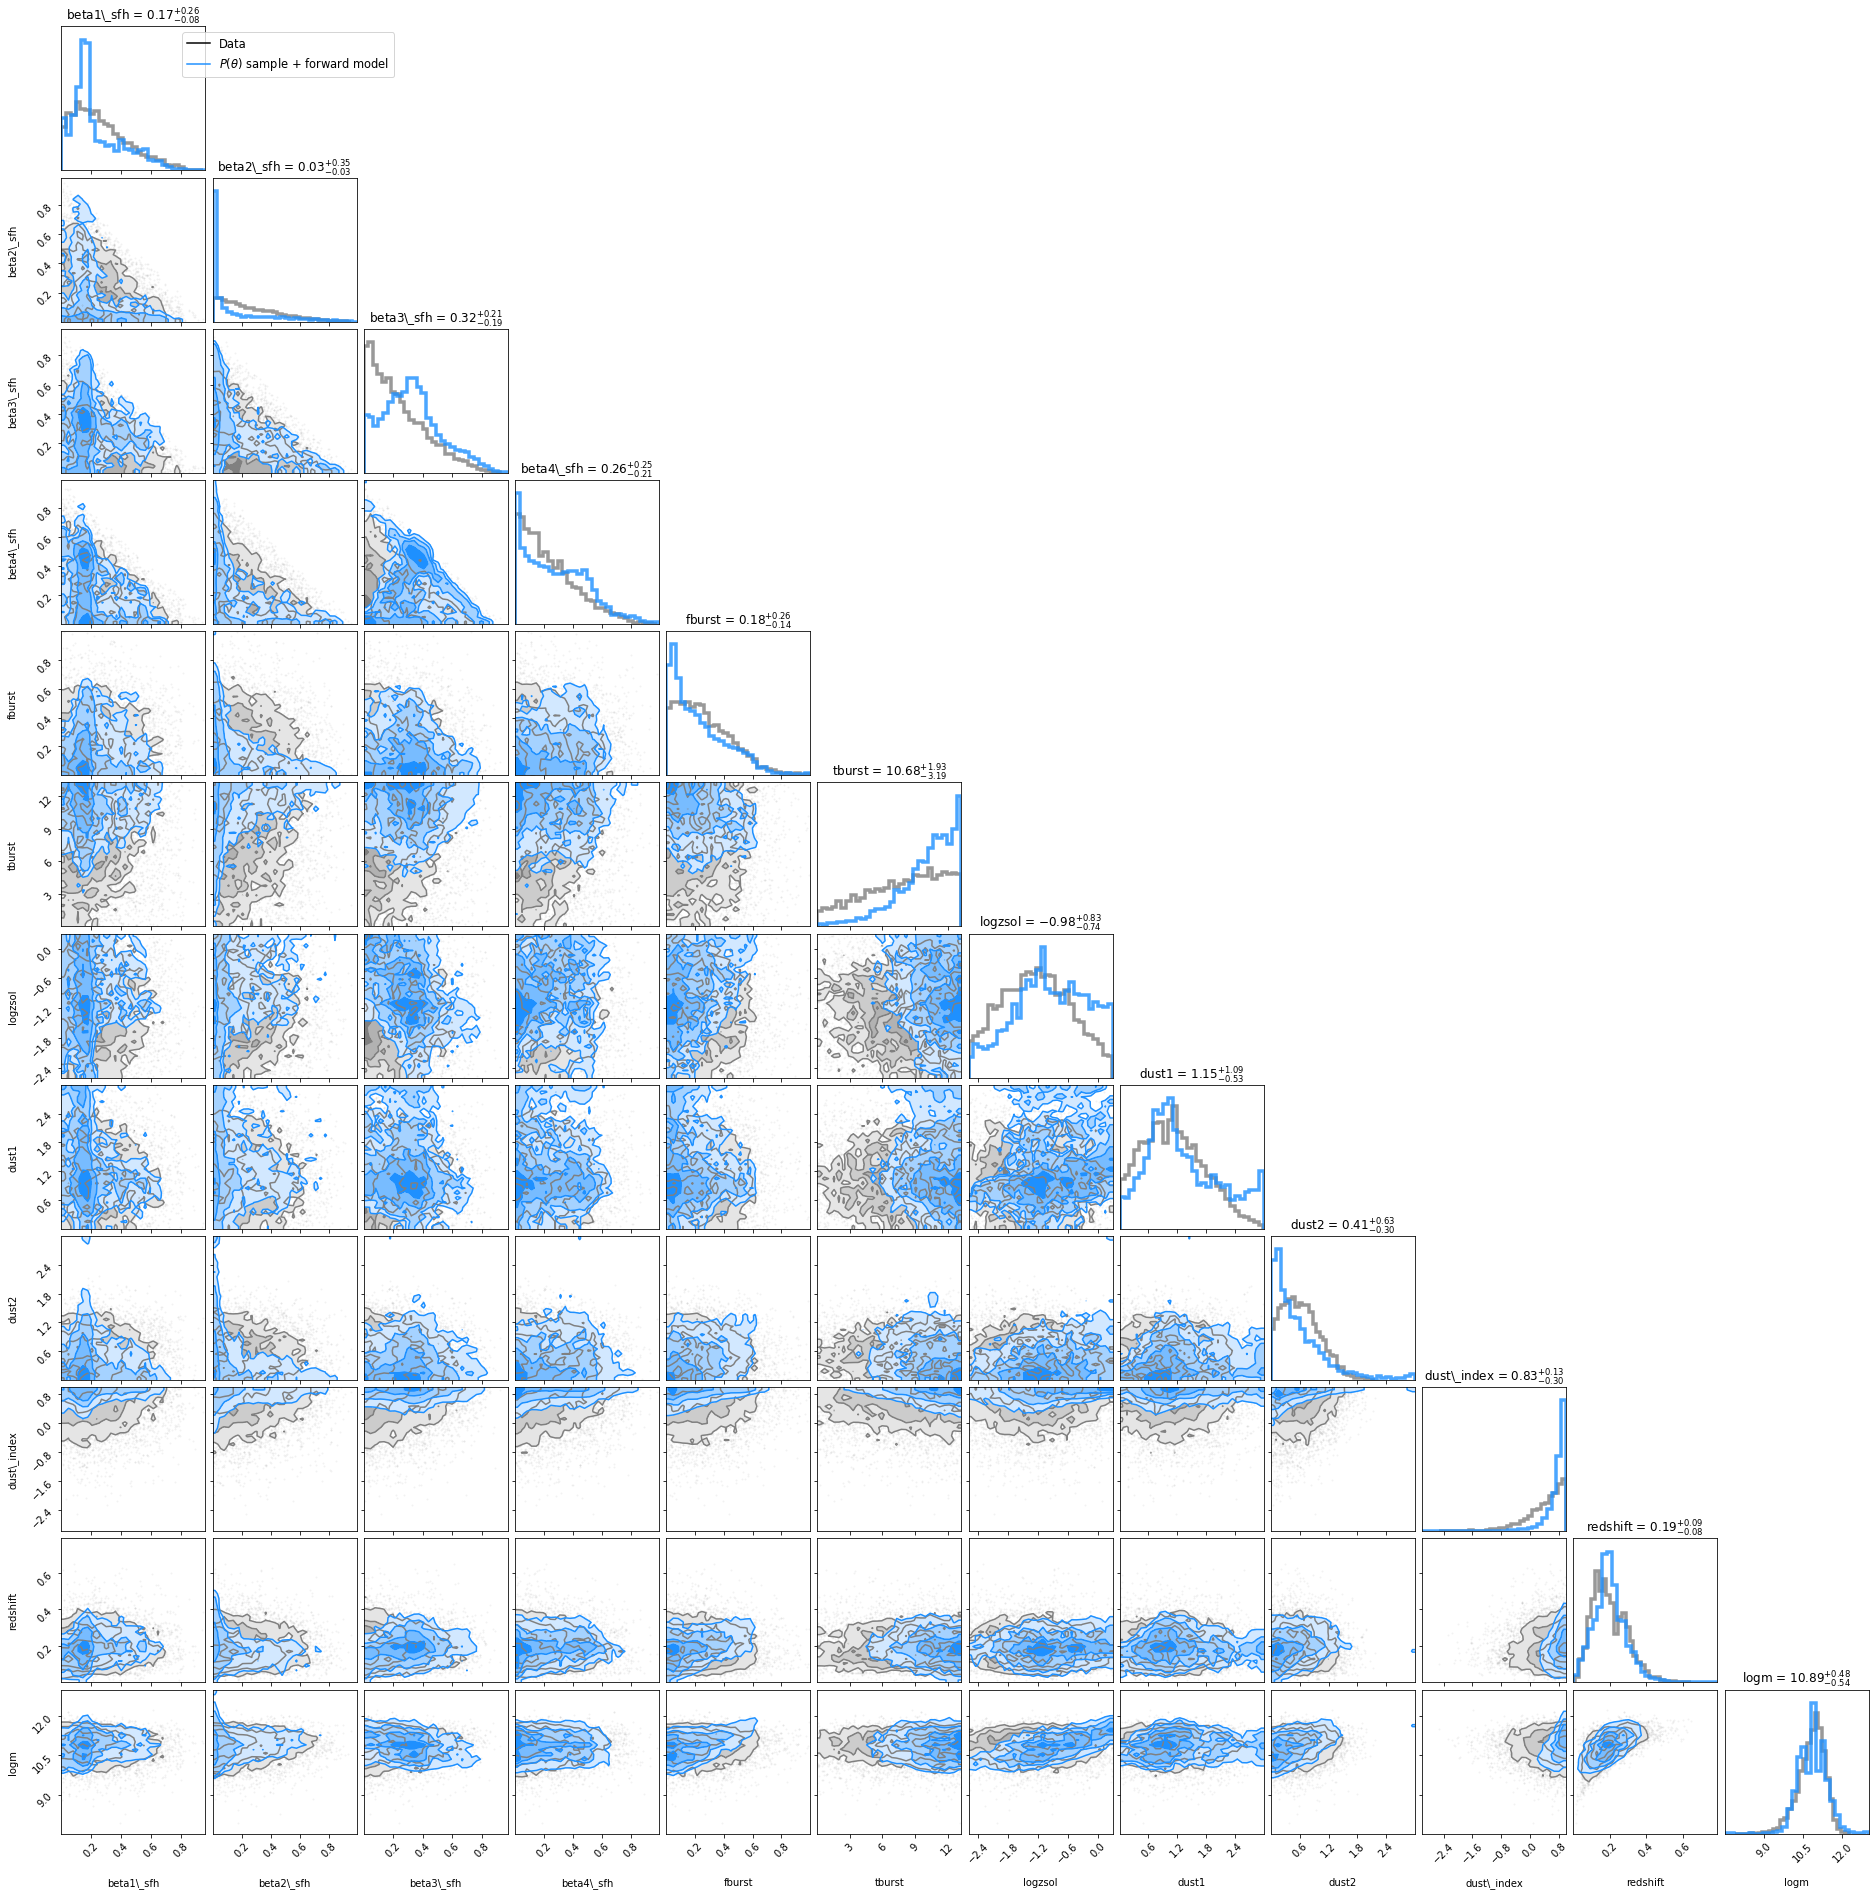

In [30]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

figure = corner.corner(true_params, 
                  labels=_labels, bins=30,
                  color='gray', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)


nf_plot = corner.corner(_samples, 
                        fig=figure,
                  labels=_labels, bins=30,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

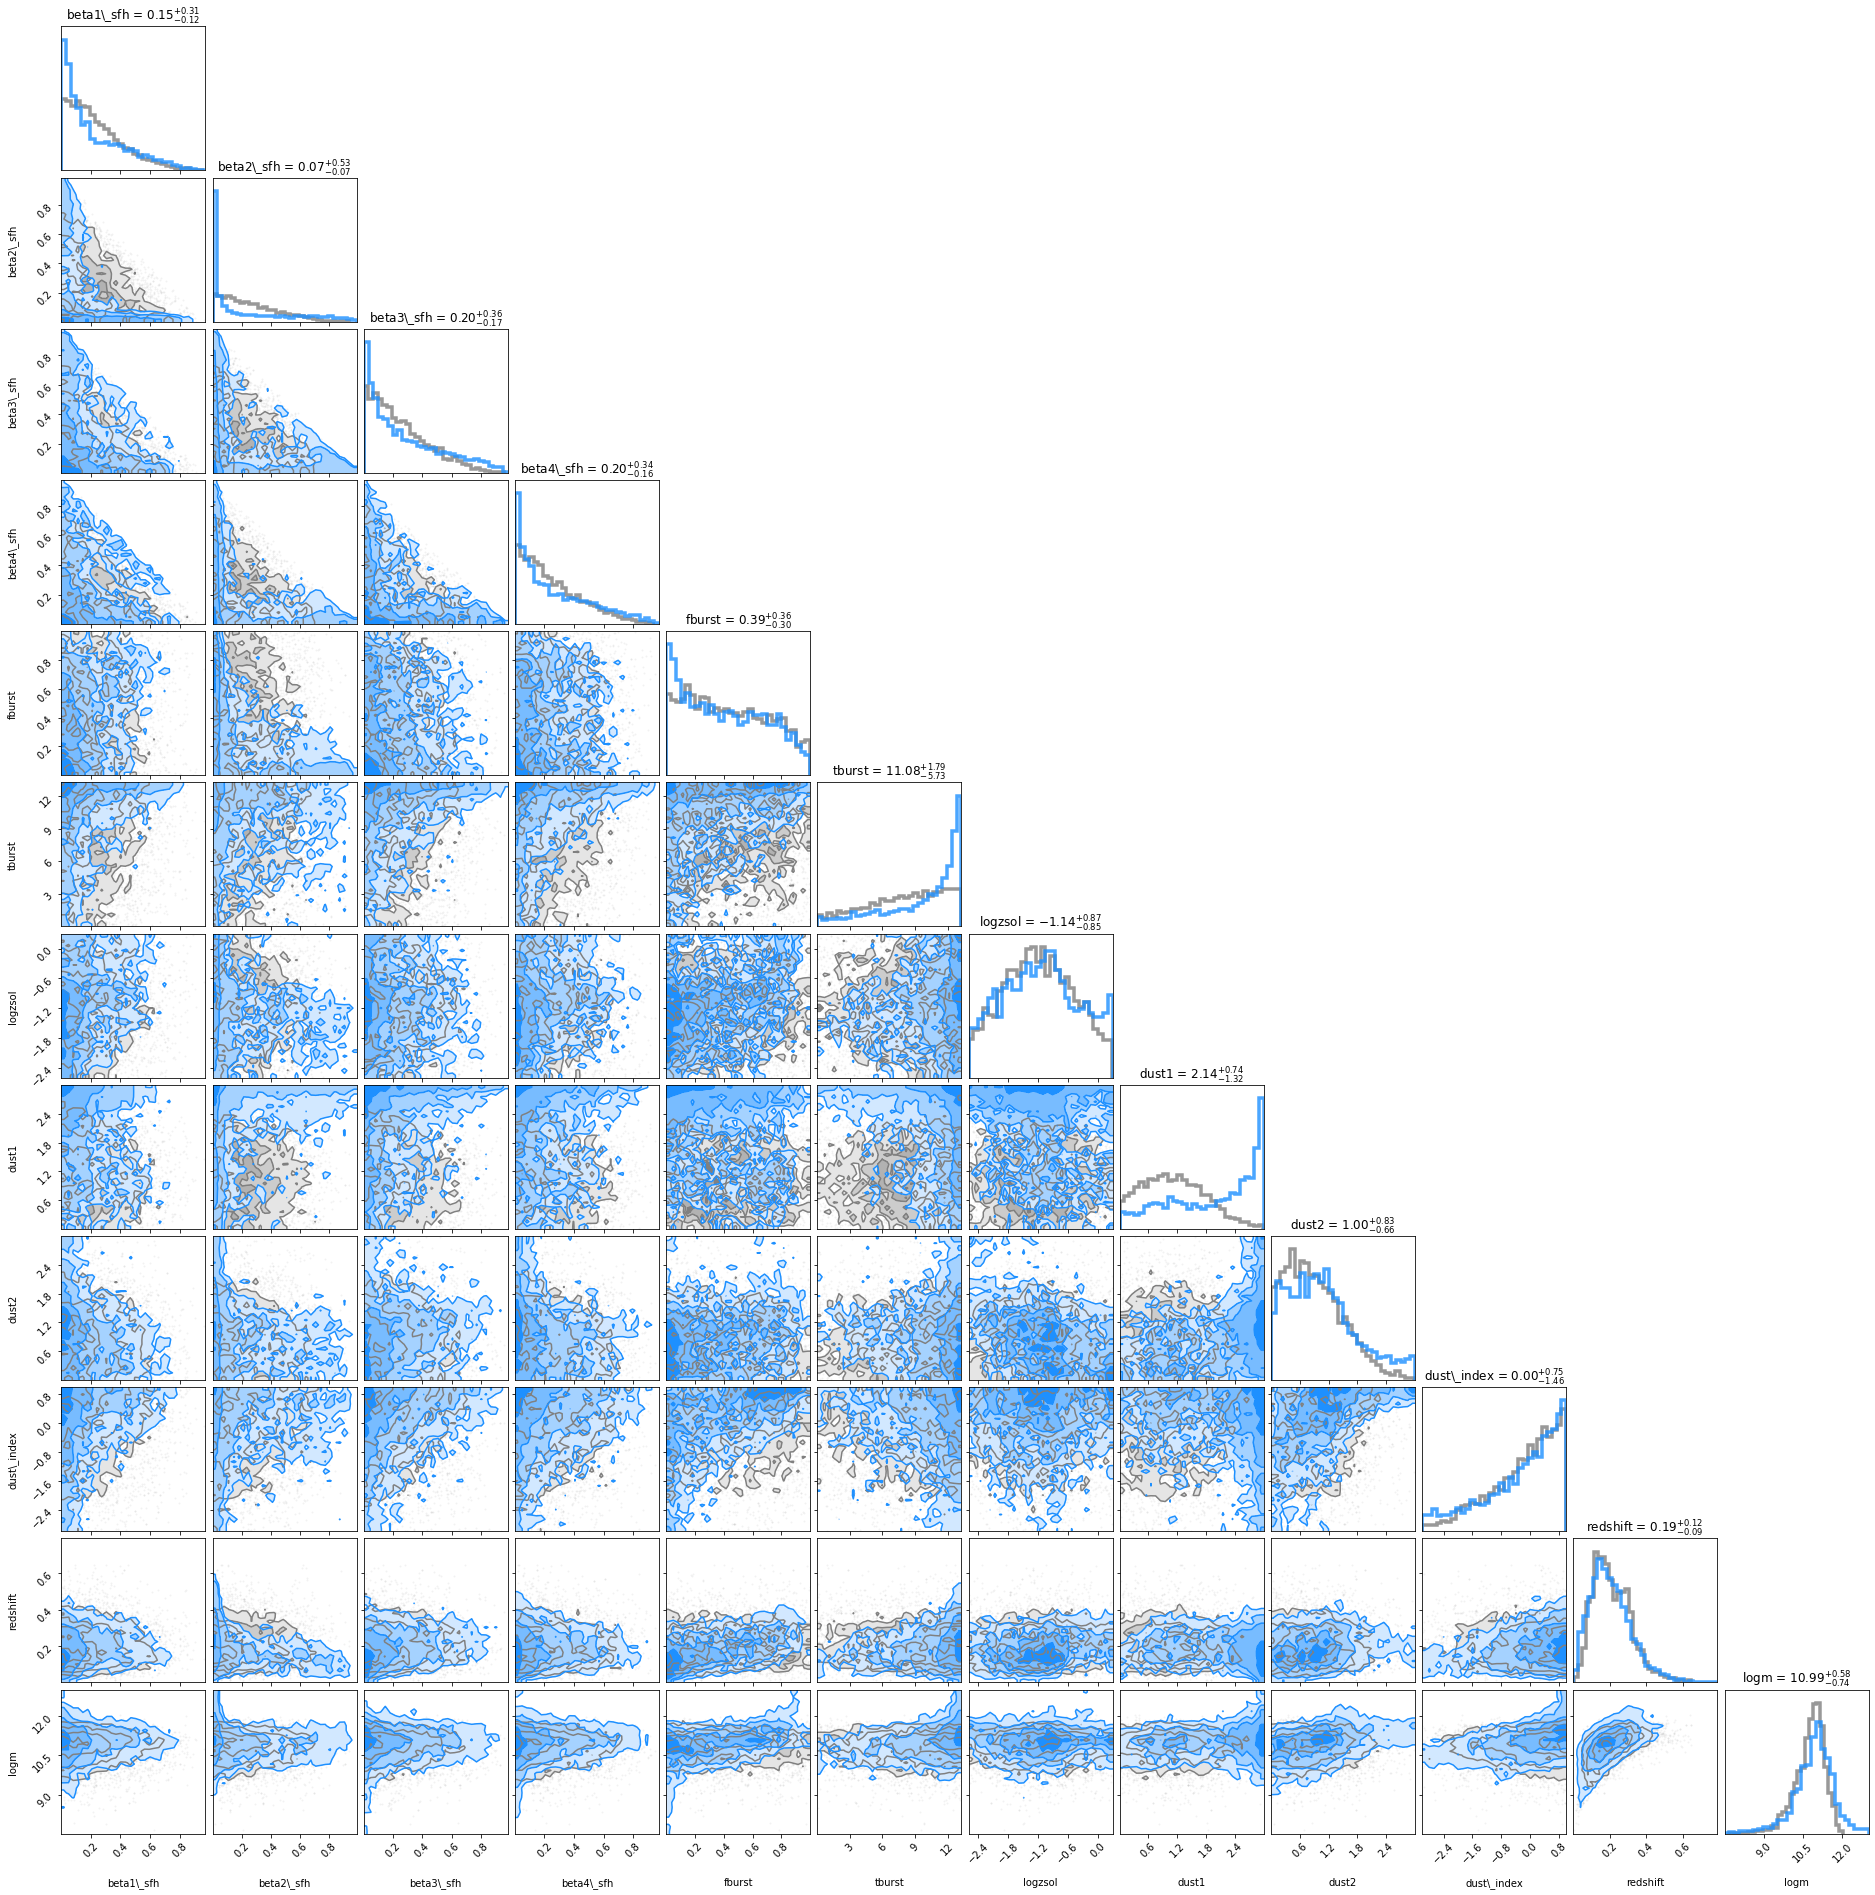

In [66]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

figure = corner.corner(true_params, 
                  labels=_labels, bins=30,
                  color='gray', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)


nf_plot = corner.corner(_samples, 
                        fig=figure,
                  labels=_labels, bins=30,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

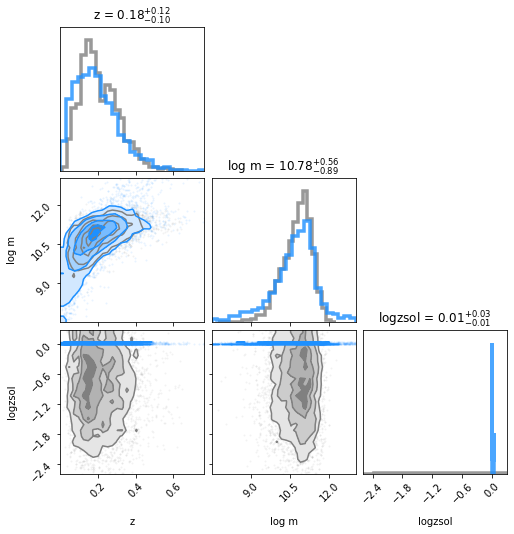

In [25]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
#                        range=[[0, 1], [8, 13], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:-1], _samples[:, -1:], _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [46]:
np.sort(true_params[:, -2])

array([0.00657144, 0.0066278 , 0.00664884, ..., 0.97983915, 0.98794556,
       0.9928388 ])

(array([193., 466., 620., 746., 738., 645., 528., 369., 229., 154., 125.,
         67.,  36.,  32.,  12.,  10.,   8.,   5.,   3.,   1.,   6.,   2.,
          0.,   1.,   4.]),
 array([0.00657144, 0.04602214, 0.08547283, 0.12492352, 0.16437422,
        0.20382491, 0.24327561, 0.2827263 , 0.322177  , 0.36162769,
        0.40107839, 0.44052908, 0.47997977, 0.51943047, 0.55888116,
        0.59833186, 0.63778255, 0.67723325, 0.71668394, 0.75613463,
        0.79558533, 0.83503602, 0.87448672, 0.91393741, 0.95338811,
        0.9928388 ]),
 <BarContainer object of 25 artists>)

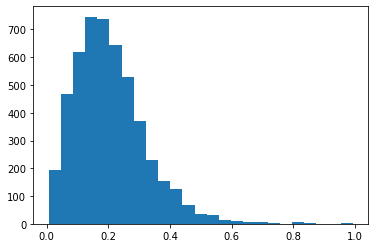

In [66]:
plt.hist(true_params[:, -2], bins=25)
# plt.xlim(0, 0.15)

In [64]:
from popsed.models import NMF_ZH
model = NMF_ZH(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [63]:
params = np.hstack([_samples[:, -1:], _samples[:, :-1]])

In [69]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))
zmw = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=tt[-1], dt=1)
    age[i] = model.tage_MW(tt[:-1], zred=tt[-1])
    zmw[i] = model.Z_MW(tt[:-1], zred=tt[-1])

In [78]:
redshift = params[:, -1]
logmstar = params[:, 0]
logzsol = np.log10(zmw / 0.019)

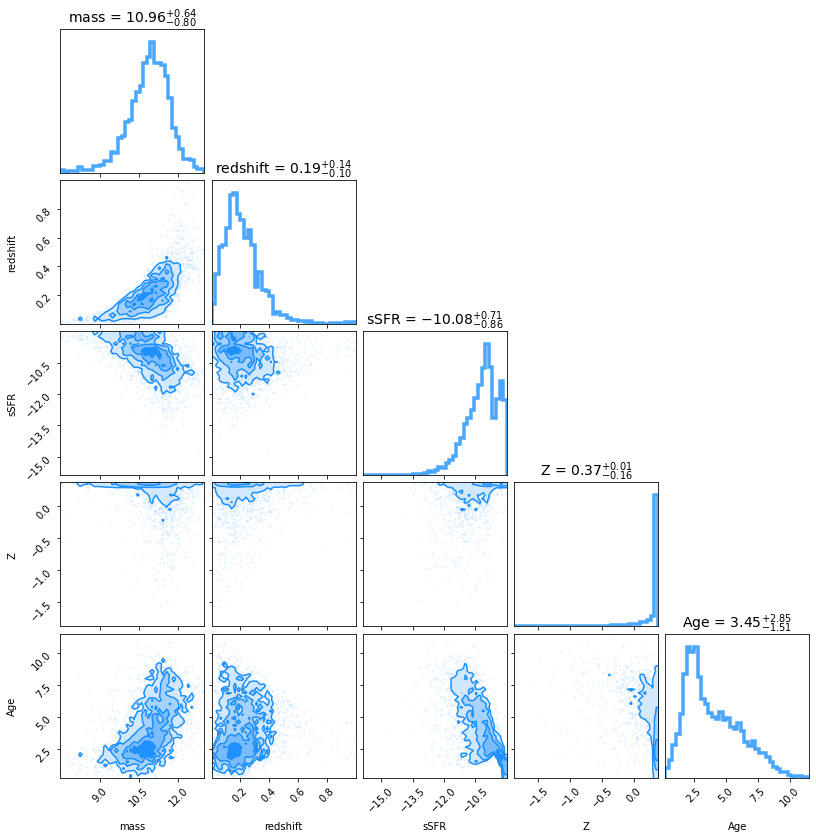

In [79]:
figure = corner.corner(np.vstack([logmstar, redshift, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['mass','redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [35]:
a, b = np.histogram(z_mass_truth[:, 0].ravel(), bins=35, range=(0, 0.5))
b[np.argmax(a)]

0.15714286

In [59]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()

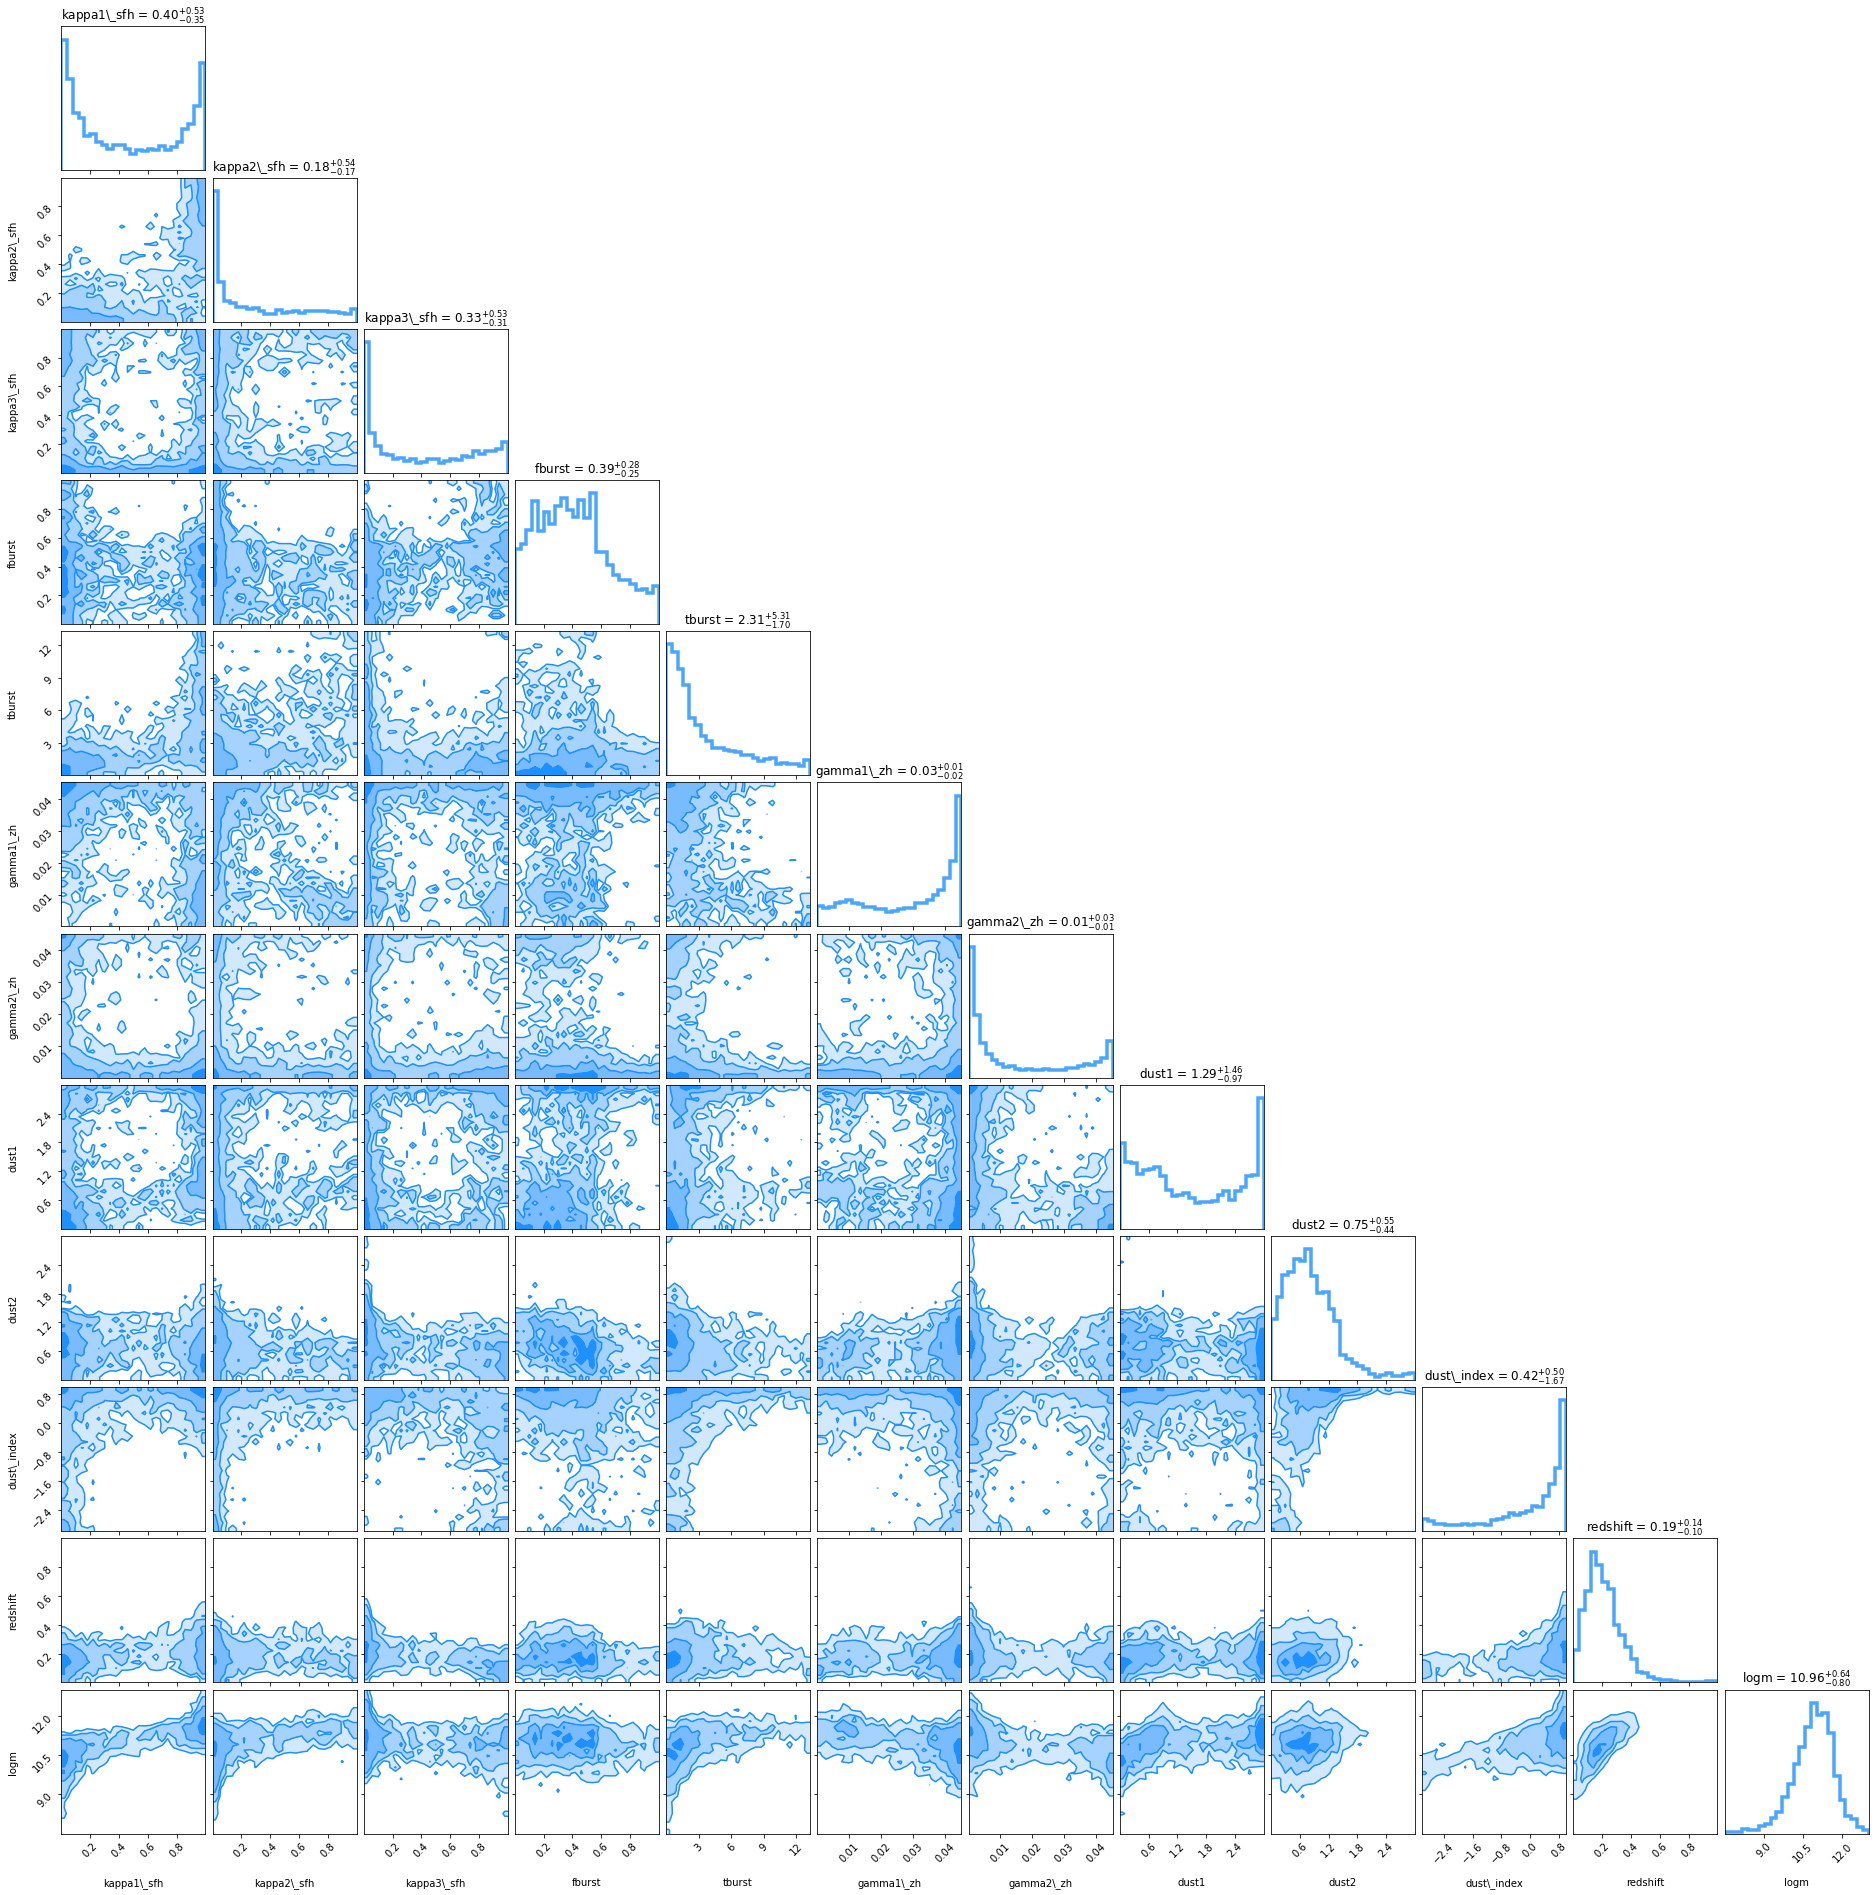

In [60]:
_labels = [f'kappa{i}_sfh' for i in range(1,4)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples_unt, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))